## Solution: Probability density distribution

Firstly we need to import the necessary libraries and define constants/functions to ensure this notebook can run independently.

In [1]:
#------------------------import libraries-----------------------#

import numpy as np #probably gonna need it!
import matplotlib.pyplot as plt #for plotting purposes
from scipy.integrate import quad #for integration
from ipywidgets import interact, fixed #to use widgets
import ipywidgets as widgets


#------------------------define constants-----------------------#

m = 9.11 * 10**(-31) #Particle mass in Kg (in this case mass of an electron)
e = 1.6 * 10**(-19) #an electron volt
hbar = (6.626 * 10**(-34)) / (2 * np.pi) #Planck's constant divided by 2Pi

L = 10**(-10) #width of the infinite well
A = np.sqrt(2 / L) # normalisation constant
w = 0.2 * L #width of the central square perturbation

#------------------------define functions-----------------------#

#energy of the unperturbed system
def energy(n):
    """
    Function to calculate the energy of the particle in an infinite 
    potential well in a particular quantum state
    
    Returns:
        energy : float
                 the energy of the particle
                 
    Parameter:
        n : integer
            the state of the wavefunction
    """
    
    energy = (n**2 * (np.pi)**2 * (hbar**2)) / (2 * m * L**2)
    return energy

#wavefunction without the perturbation
def unperturbed(n, x):
    """
    Function to calculate the value of the wavefunction at a given point in the infinite potential well 
    without any perturbation
    
    Returns:
        psi : float
              the value of the wavefunction
        
    Parameters:
        n : integer
            the order of the wavefunction
            
        x : float
            the position of the particle in the infinite potential well
    """
    
    psi = A * np.sin((n * np.pi * x) / L) #the solution to the unperturbed wavefunction in an infinite potential well
    return psi


#-------------all the functions required to plot the corrected wavefunction-----------------#

def integral(n, k, V, w):
    """
    Function to calculate individual integrals, which will later be summed when finding the first-order
    correction to the wavefunction.
    
    Returns:
        perturb_1 : float
        
    Parameters:
        n : integer
            principle quantum number
            
        k : integer
            dummy variable. represents the principle quantum number and is what we will sum over in a later function
            
        V : float
            magnitude of the square perturbation
            
        w : float
            width of the central square pertubation
    """
    
    if w > L:
        print ("Perturbation width exceeds that of the infinite well. Reduce perturbation width.")
        
    else:
        def integrand(x):
            """
            Function to establish the integrand to be used when calculating the perturbation. Must do this 
            as cannot square the 'solution' function which is previously defined
            """
            
            return (A * np.sin((n * np.pi * x) / L)) * (np.conj(A * np.sin((k * np.pi * x) / L))) * V
        
        perturb_1 = quad(integrand, L/2 - w/2, L/2 + w/2)
        return perturb_1[0]
    
def sum_1(n, kmax, V, w):
    """
    Function to store integral values which will later be used to find the value of the corrected wavefunction.
    For even values of k because of the symmetry in the integral for these values means that the integral is 
    equal to zero. We set these elements to zero without computing the integral to save time.
    
    Returns:
        sum_1 : array
                array containing coefficients which will be used to find the corrected wavefunction.
        
    Parameters:
        n : integer
            principle quantum number
            
        kmax : integer
               value of the dummy variable up to which we will sample
        
        V : float
            magnitude of the square perturbation
        
        w : float
            width of the central square pertubation
    """
    
    sum_1 = np.empty(kmax)
    
    for i in range(0, kmax):
        if i + 1 == n:
            sum_1[i] = 0
        #elif (i % 2) != 0:
           # sum_1[i] = 0
        else:
            value = integral(n, i + 1, V, w) / (energy(n) - energy(i + 1))
            sum_1[i] = value
    
    return sum_1

def psi_correc(n, kmax, V, w):
    """
    Function to find the corrected wavefunction for a particle in an infinite potential well with a small
    central square perturbation.
    
    Returns:
        new_psi : array
                  contains the value of the corrected wavefunction for x-positions in the range of the well
                  
    Parameters:
        n : integer
            principle quantum number
            
        kmax : integer
               value of the dummy variable up to which we will sample
        
        V : float
            magnitude of the square perturbation
        
        w : float
            width of the central square pertubation
    """
    
    new_psi = np.empty(Nx) #empty array to store (first-order) corrected wavefunctions
    
    for x in range(0, Nx):
        value = 0
        
        for i in range(0, kmax):
            value += (sum_1(n, kmax, V, w)[i] * unperturbed(i + 1, x * xstep))
        
        new_psi[x] = value + unperturbed(n, x * xstep)
    
    return new_psi

#------functions to add the unperturbed wavefunction and the perturbation to the plots-------#
#the perturbation itself
def perturbation(V, w):
    """
    A function to find the perturbation
    
    Returns:
        perturb : array
                  stores individual values of the perturbed wavefunction over a range of positions.
                  
    Parameters:
        V : float
            magnitude of the square perturbation
            
        w : float
            width of the perturbation
    """
    
    perturb = np.empty(pert_Nx) #random array to fill with values of the perturbation depending on arguments
    
    if w == 0:
        perturb = np.zeros(pert_Nx)
    else:
        for i in range(0, pert_Nx):
            if (L + w) / 2 < i * (L / pert_Nx) or i * (L / pert_Nx) < (L - w) / 2:
                perturb[i] = 0
            else:
                perturb[i] = V
            
    return perturb

def unpert_psi(n):
    """
    Function to allow us to plot the unperturbed wavefunction for an infinite potential well
    
    Returns:
        psi : array
              the value of the wavefunction
        
    Parameters:
        n : integer
            the order of the wavefunction
    """

    psi = np.empty(Nx)
    
    for x in range(0, Nx):
        psi[x] = unperturbed(n, x * xstep)
        
    return psi

We can simply find the the probability distribution by squaring the absolute value of the wavefunction. Below we also have a function to help us plot the unperturbed probability distribution for comparison. We plot the probability distribution in a the same manner as plotting the wavefunction except using the `prob_dens` function.

In [2]:
def prob_dens(n, kmax, V, w):
    """
    Function to store values of the probability density distribution.
    
    Returns:
        prob : list
               stores individual values of the probability density over a range of positions.
               
    Parameters:
        n : integer
            principle quantum number
            
        kmax : integer
               value of the dummy variable up to which we will sample
        
        V : float
            perturbation magnitude
            
        w : float
            width of the square perturbation
    """

    prob = np.empty(Nx)
    psi = psi_correc(n, kmax, V, w)
    for i in range(0, Nx):
        prob[i] = abs(psi[i])**2
    
    return prob

def unpert_prob(n):
    """
    Function to allow us to plot the probability distribution for an infinite potential well
    
    Returns:
        prob : array
              the value of the probability density
        
    Parameters:
        n : integer
            the order of the wavefunction
    """

    prob = np.empty(Nx)
    psi = unpert_psi(n)
    
    for i in range(0, Nx):
        prob[i] = abs(psi[i])**2
        
    return prob

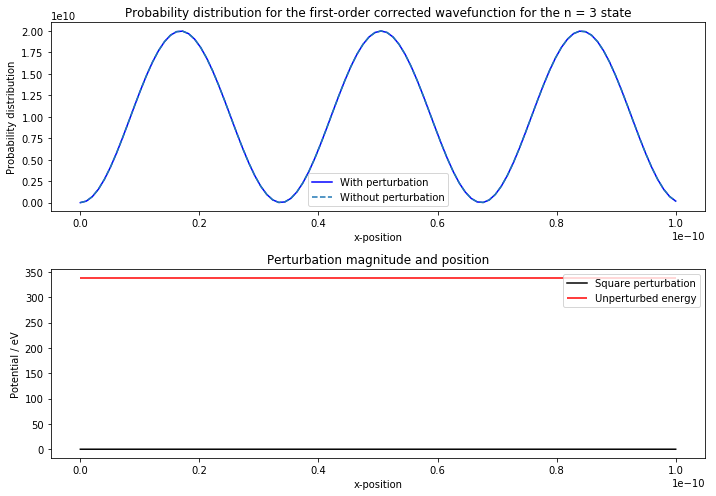

In [3]:
Nx = 100 #number of x-positions over which we will sample
xstep = L / Nx #increments in x-position
pert_Nx = 10000 #number of x-positions we'll sample the perturbation over

@interact(n = (1, 5, 1), kmax = fixed(10), V = (-1e3, 1e3, 5e1), w = (0.0, L * 1e10, 0.1))
def plot_prob_dens(n, kmax, V, w):
    """
    A function to plot the probability density distribution as a function of position. Also plots
    the magnitude and position of the perturbation as well as the energy of the system. The parameters 
    are connected to widgets to allow better visualisation of the evolution of the function.
    
    Returns:
        plot of the probability density distribution
        plot of the square perturbation and the energy of the system
      
    Parameters:
        n : integer
            principle quantum number
            
        kmax : integer
               value of the dummy variable up to which we will sample
        
        V : float
            magnitude of the perturbation
            
        w : float
            width of the perturbation
    """
    Nx = 100 #number of x-positions over which we will sample
    xstep = L / Nx #increments in x-position
    
    fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 7)) 
    
    x_pos1 = np.linspace(0, L, Nx)
    ax1.plot(x_pos1, prob_dens(n, kmax, V * e, w * L), 'b', label = 'With perturbation')
    ax1.plot(x_pos1, unpert_prob(n), '--', label = 'Without perturbation')
    ax1.legend(loc = 'best')
    ax1.set_xlabel('x-position')
    ax1.set_ylabel('Probability distribution')
    ax1.set_title('Probability distribution for the first-order corrected wavefunction for the n = %i state' %n)
    
    
    pert_Nx = 10000 #number of x-positions we'll sample the perturbation over
    x_pos2 = np.linspace(0, L, pert_Nx)
    ax2.plot(x_pos2, perturbation(V, w * L), 'k', label = 'Square perturbation')
    ax2.hlines(energy(n) / e, 0, L, 'r', label = 'Unperturbed energy')
    ax2.legend(loc = 'best')
    ax2.set_xlabel('x-position')
    ax2.set_ylabel('Potential / eV')
    ax2.set_title('Perturbation magnitude and position')
    
    fig.tight_layout() #increase the gap between subplots
    return plt.show()

Contrary to what you might have expected, the probability increases in the area where the perturbation lies. One might have thought that the probability would be reduced in this area because particles prefer to exist in areas with lower energies so let's think about why the plot is as it is.

When the perturbation magnitude is less than the energy of the system, the particle still has sufficient energy to access the region with the perturbation, however it has a lower kinetic energy now. This means that it moves more slowly and so spends more time in that region, hence an increased probability of existing in that area. We can also see that it moves more slowly in that area because of the increased wavelength of the probability distribution, indicating an increased de Broglie wavelength, which is consistent with a lower momentum, and hence, velocity. 

We see a similar shape when the perturbation magnitude far exceeds the energy of the unperturbed system, but we should not read into this too much because the key requirement of perturbation theory is that the perturbation should be small in comparison to the unperturbed Hamiltonian.

To check that this probability distribution is correct, we will integrate over the limits of the well. Once again, we will use the `numpy.trapz` function to ensure a total probability of one.

In [4]:
Nx = 1000
def tot_prob(n, kmax, V, w):
    """
    A function to check that the total probability of the particle existing inside the well is 1.
    
    Returns:
        total_prob : float
                     the total probability
    
    Parameters:
        n : integer
            principle quantum number
            
        kmax : integer
               value of the dummy variable up to which we will sample
        
        V : float
               the perturbation magnitude. we sample perturbation magnitudes up to this value
               
        w : float
            width of the perturbation
    """
    
    total_prob = np.trapz(prob_dens(n, kmax, V, w), np.linspace(0, L, Nx))
    return total_prob

In [5]:
tot_prob(3, 10, 100*e, 0.2*L)

1.0152478296292493

Fortunately the total probability is approximately one for small perturbations. This is not the case for higher perturbation magnitudes but this is indicative of perturbation theory breaking down when the perturbation far exceeds the unperturbed Hamiltonian.